# Molecular ISDF Timings

## Running on the Remote

On MPSD:
```
tmux new -s jlab
source programs/isdfBenchmarks/.venv/bin/activate
jupyter lab --no-browser --ip=0.0.0.0 --port 8888
```

Detach with `Ctrl-b d`
Reattach with: `tmux attach -t jlab`
Paste the Jupyter URL into `Settings > Jupyter > Jupyter Servers > Configured servers`

## TODOs
* For `24_anthracene`, plot comparison of the timings as a function of the number of MPI processes



In [35]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from isdfbenchmarks.parser.profiling import parse_time


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Parse ISDF profiling times

results_root = Path("/home/bucchera/exchange_calcs/isdf")
directories =  ["24_anthracene", "30_tetracene", "36_pentacene", "42_ether_crown"]

isdf_results = {}
for dir in directories:
    cumulative, self = parse_time(results_root / dir / "profiling/time.000000")
    isdf_results[dir] = {'cumulative': cumulative, 'self':self}


In [3]:
# Parse reference ACE profiling time

results_root = Path("/home/bucchera/exchange_calcs/reference_ace")
directories =  ["24_anthracene", "30_tetracene", "36_pentacene", "42_ether_crown"]

ref_results = {}
for dir in directories:
    cumulative, self = parse_time(results_root / dir / "profiling/time.000000")
    ref_results[dir] = {'cumulative': cumulative, 'self':self}
    

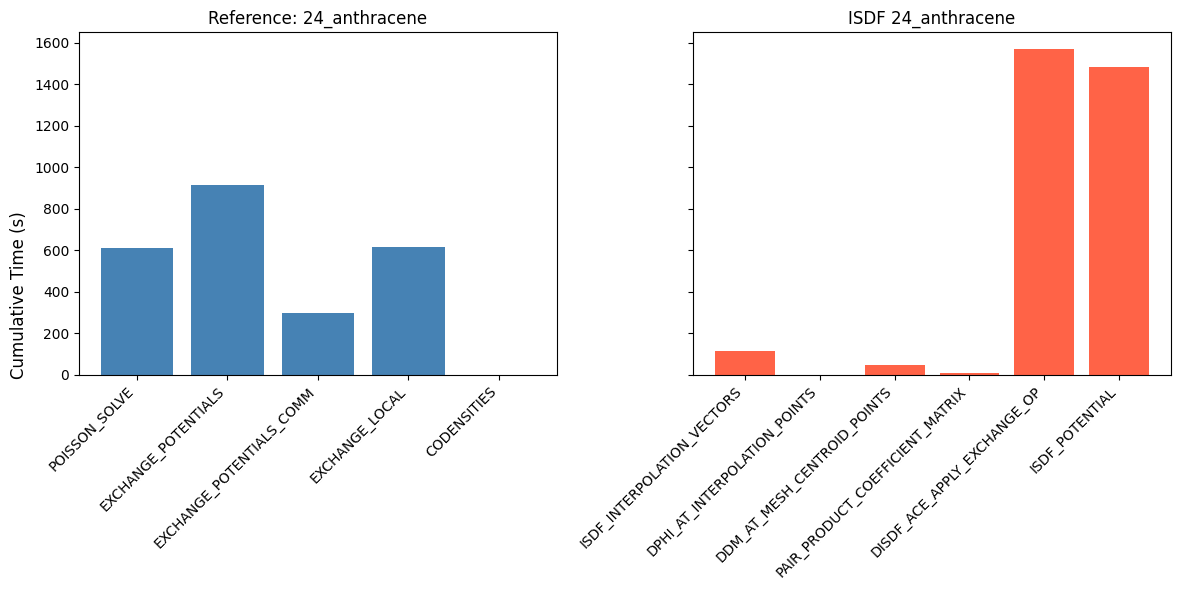

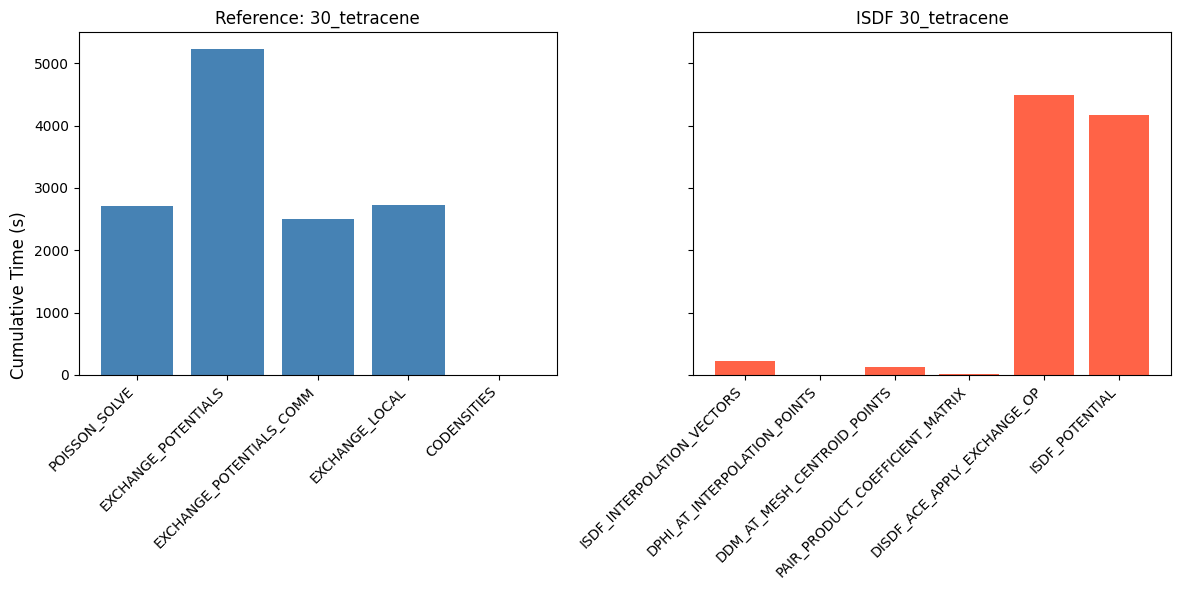

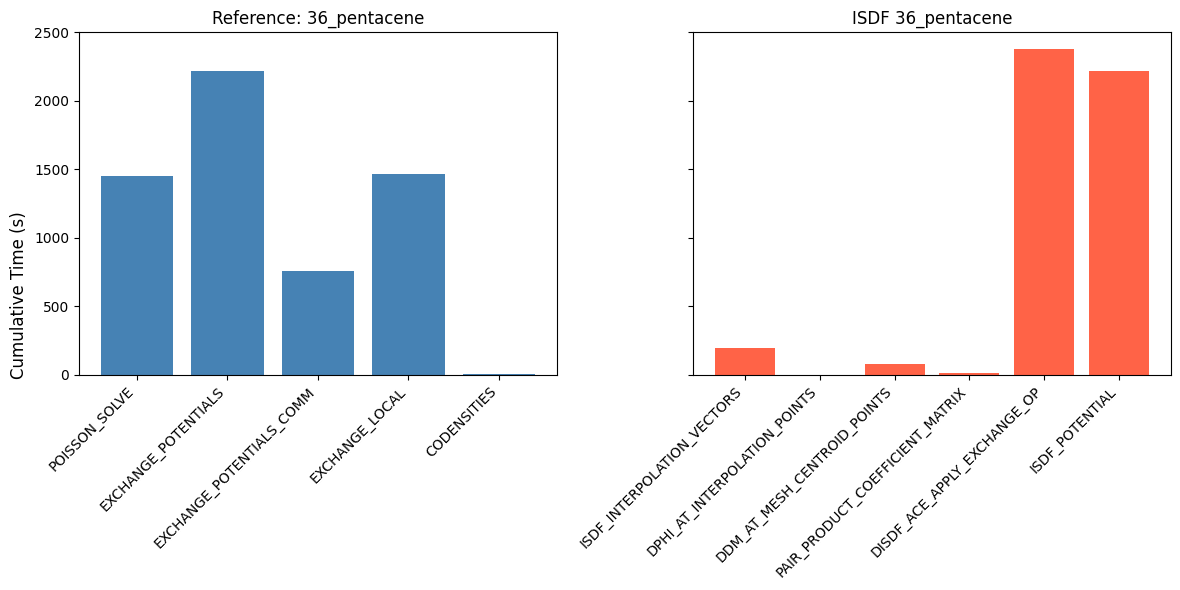

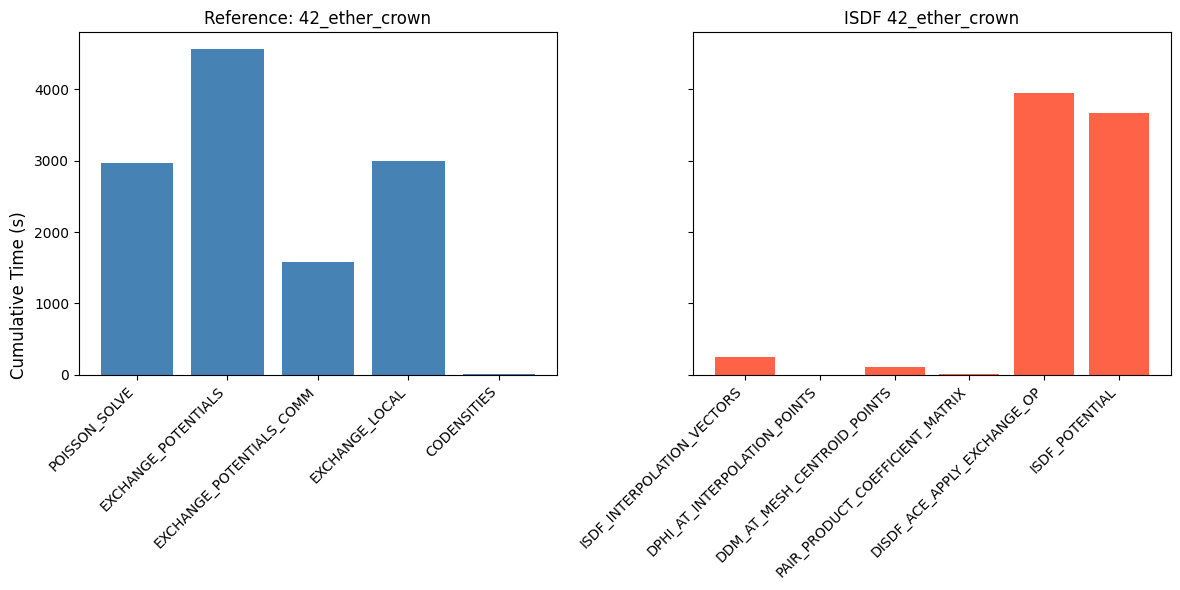

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Functions
def add_bars(ax, labels, values, *, label=None, color=None, width=0.8, rot=45):
    x = np.arange(len(labels))
    ax.bar(x, values, width=width, label=label, color=color)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=rot, ha='right')
    if label:
        ax.legend()
    return ax

to_total_time = lambda t, routines: [t[name]['TOTAL_TIME'] for name in routines]
to_time_per_call = lambda t, routines: [t[name]['TIME_PER_CALL'] for name in routines]

# Reference routines
ref_routines = ['POISSON_SOLVE', 
                'EXCHANGE_POTENTIALS', 
                'EXCHANGE_POTENTIALS_COMM', 
                'EXCHANGE_LOCAL', 
                'CODENSITIES']

# Extract times of relevant routines
isdf_routines = ['ISDF_INTERPOLATION_VECTORS',
            'DPHI_AT_INTERPOLATION_POINTS',
            'DDM_AT_MESH_CENTROID_POINTS',
            'PAIR_PRODUCT_COEFFICIENT_MATRIX',
            'DISDF_ACE_APPLY_EXCHANGE_OP',
            'ISDF_POTENTIAL']

# Plotting.
for dir in directories:
    fig, (ax_ref, ax_isdf) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    add_bars(ax_ref,  ref_routines,  to_total_time(ref_results[dir]['cumulative'], ref_routines),  color='steelblue')
    ax_ref.set_title(f'Reference: {dir}')
    
    add_bars(ax_isdf, isdf_routines, to_total_time(isdf_results[dir]['cumulative'], isdf_routines), color='tomato')
    ax_isdf.set_title(f'ISDF {dir}')
    
    fig.supylabel('Cumulative Time (s)')
    fig.tight_layout()


In [18]:
"""
Looks like the Poisson solution is just taking way more time in the ISDF code. Check:
"""

# Seems to suggest that ISDF is simply calling poisson solver 2.5x more than the reference code. 
# Reason might be because the original code is a) MPI parallelised over codensities and 
# b) Exploits the symmetry (i, j) = (j, i) for the codensities. The latter cannot be exploited for ISDF
print(isdf_results['cumulative']['POISSON_SOLVE']['NUM_CALLS'])
print(ref_results['cumulative']['POISSON_SOLVE']['NUM_CALLS'])


12453
5061


## Initial Data Analysis for Anthracene

Ref:
```
EXCHANGE_POTENTIALS_COMM                           480      408.259299        0.850540        0.000003       0.0       0.0    36.0 |       408.259299        0.850540       0.0       0.0    36.0
POISSON_SOLVE                                     5061      595.460209        0.117657        0.042427       0.0      61.6    52.6 |       329.263829        0.065059       0.0       0.0    29.1
SGFFT                                            10082      259.366159        0.025726        0.022204       0.0       0.0    22.9 |       259.366159        0.025726       0.0       0.0    22.9
```

ISDF:
```
POISSON_SOLVE                                    12453     1486.043079        0.119332        0.043490       0.0      60.7    74.3 |       821.395527        0.065960       0.0       0.0    41.1
SGFFT                                            24862      642.859033        0.025857        0.022608       0.0       0.0    32.2 |       642.859033        0.025857       0.0       0.0    32.2
ISDF_GET_INTERPOLATION_POINTS                       22      190.160663        8.643666        6.451695       0.0       0.0     9.5 |       190.160663        8.643666       0.0       0.0     9.5
```

Running single MPI-process jobs in:

```
/home/bucchera/exchange_calcs/compare_anthracene/ref_np1
/home/bucchera/exchange_calcs/compare_anthracene/isdf_np1_250points
```

Submit the rest and confirm at what number of interpolation points does ISDF converge?
* isdf_np1_350points
* isdf_np1_450points
* isdf_np1_565points

I assume that the Poisson calls are distributed and this roughly scales with the state distribution



## Average SCF Time as a Function of Number of Occupied States

In [6]:
""" Parse average SCF time as a function of Number of occupied states
"""
from typing import List
from pathlib import Path

from isdfbenchmarks.parser import stdout

nocc = {'24_anthracene': 33, '30_tetracene': 42, '36_pentacene': 51, '42_ether_crown': 54}

# All single node jobs. 4 MPI, 8 OMP per process
molecules = ['24_anthracene', '30_tetracene', '36_pentacene', '42_ether_crown']

# Note, these will use more than one node. Either need to normalise OR run the above with more nodes
# For the sake of comparison to reference implementation, it's reasonable to normalise
to_run = ['60_buckminster', '73_chlorophyll', '84_c84']

# Parse SCF per time step
isdf_root = Path("/home/bucchera/exchange_calcs/isdf")

# Note, I need to change this to my repeat set of references, to CONFIRM that I have
# used consistent builds for reference and ISDF
ref_root = Path("/home/bucchera/exchange_calcs/reference_ace")

def parse_scf_times(root: Path, molecules: List[str]) -> dict:
    scf = {}
    for molecule in molecules:
        file = root / molecule / 'terminal.out'
        with open(file, mode='r') as fid:
            lines = fid.read()
        scf[molecule] = stdout.parse_scf_time(lines)
    return scf

ref_scf = parse_scf_times(ref_root, molecules)
isdf_scf = parse_scf_times(isdf_root, molecules)


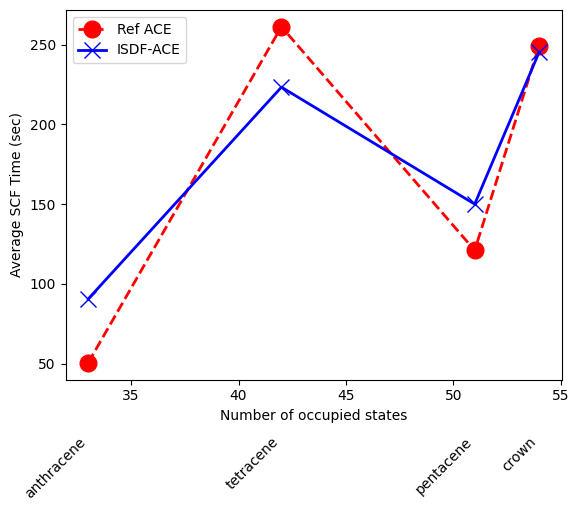

In [7]:
""" Plot average SCF time as a function of Number of occupied states
"""
import numpy as np
import matplotlib.pyplot as plt


# Average SCF time as a function of number of occupied states
n_molecules = len(list(nocc))
avg_scf = np.empty(shape=(2, n_molecules))

assert list(ref_scf) == list(isdf_scf), "SCF times must be for a consistent set of molecules"

# Occupied states
occupied = [iocc for iocc in nocc.values()]

# Times
i = 0
for key, times in ref_scf.items():
    avg_scf[0, i] = np.mean([time for time in times.values()])
    avg_scf[1, i] = np.mean([time for time in isdf_scf[key].values()])
    i += 1
    
plt.plot(occupied, avg_scf[0, :], 'ro--', linewidth=2, markersize=12, label="Ref ACE")
plt.plot(occupied, avg_scf[1, :], 'bx-', linewidth=2, markersize=12, label="ISDF-ACE")
plt.xlabel("Number of occupied states")
plt.ylabel("Average SCF Time (sec)")

for key, xpos in nocc.items():
    label = key.split('_')[-1]
    plt.text(xpos, plt.ylim()[0] - 0.15*(plt.ylim()[1]-plt.ylim()[0]),
             label, ha='right', va='top', rotation=45)

plt.legend()


# Timing as a function of MPI processes for anthracene

## TODOs
* Run ISDF for 2 and 3 processes
* Run ref for 2 and 3 processes

# Convergence in Exact Exchange Energy as a Function of ISDF Vectors

* Single MPI process, but using threads
* Anthracene



In [37]:
""" Convergence in EXX w.r.t. number of ISDF vectors
"""
# Reference
root = Path("/home/bucchera/exchange_calcs/compare_anthracene")

with open(root / "ref_np1/terminal.out", mode='r') as fid:
    lines = fid.read()
ref_exx: dict = stdout.parse_exchange_energy(lines)

# ISDF
calculations = ['isdf_np1_250points', 'isdf_np1_350points', 'isdf_np1_450points', 'isdf_np1_565points']
isdf_vectors = ['250', '350', '450', '565']

isdf_exx = {}
for vector, folder in zip(isdf_vectors, calculations):
    file = root / folder / 'terminal.out'
    with open(file, mode='r') as fid:
        lines = fid.read()
    isdf_exx[vector] = stdout.parse_exchange_energy(lines)


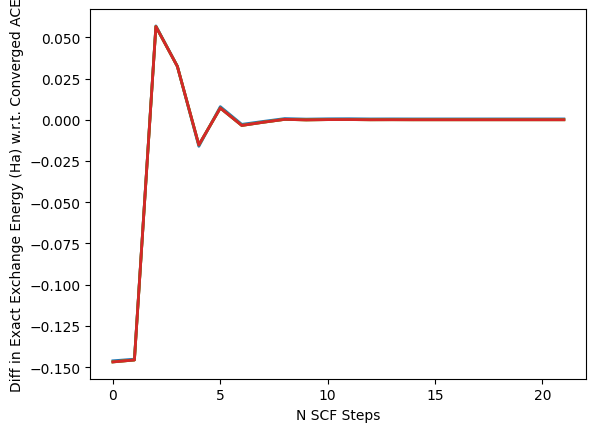

In [48]:
""" Plot data
"""
# Converged ACE EXX energy
ref_energy = [e for e in ref_exx.values()][-1]

for vector, isdf_data in isdf_exx.items():
    energies = np.asarray([e for e in isdf_data.values()]) - ref_energy
    plt.plot(list(isdf_data), energies, linewidth=2, markersize=8, label=str(vector))

plt.xlabel("N SCF Steps")
plt.ylabel("Diff in Exact Exchange Energy (Ha) w.r.t. Converged ACE")
plt.show()

N ISDF Vectors, Error in EXX (Ha)
250 0.0004866352097661064
350 1.4025429311281812e-05
450 1.1486849542663435e-06
565 9.510807901236262e-07


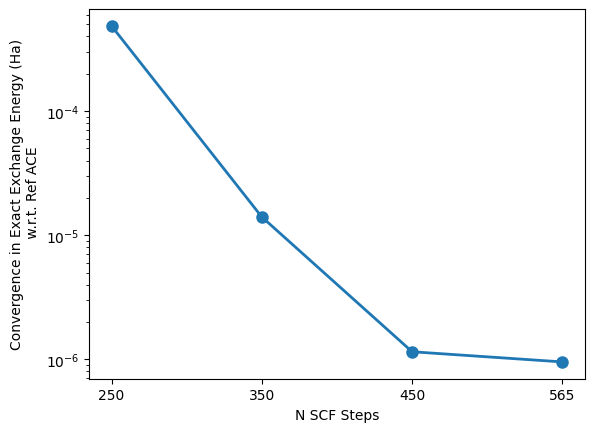

In [49]:
# Energy scale makes the above plot pointless, so plot the convergence in the SCF-converged 
# EXX relative to the ACE reference, as a function of the number of ISDF vectors

print("N ISDF Vectors, Error in EXX (Ha)")
converged_energies = []
for vector, isdf_data in isdf_exx.items():
    converged_isdf_energy = np.asarray([e for e in isdf_data.values()])[-1]
    error = converged_isdf_energy - ref_energy
    converged_energies.append(converged_isdf_energy - ref_energy)  
    print(vector, error)

plt.plot(isdf_vectors, converged_energies, 'o-', linewidth=2, markersize=8)
plt.yscale("log")
plt.xlabel("N SCF Steps")
plt.ylabel("Convergence in Exact Exchange Energy (Ha)\n w.r.t. Ref ACE")
plt.show()
